In [2]:
import os
import time
import json
import asyncio
import datetime

import sys
sys.path.append('/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/')


from style_utils import load_vgg_model, load_and_preprocess_images, GramMatrix, weighted_style_correlation, load_and_preprocess_png

from vertexai.generative_models import GenerativeModel, Part

from src.tools.segment import segment_image 
from src.tools.segmentation_eval import segmentation_evaluator
from src.tools.oneshot_segGPT import seggpt_inference_img
from src.tools.mitonet import mitonet_inference

/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/Scenario_Improving/style_utils.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.l

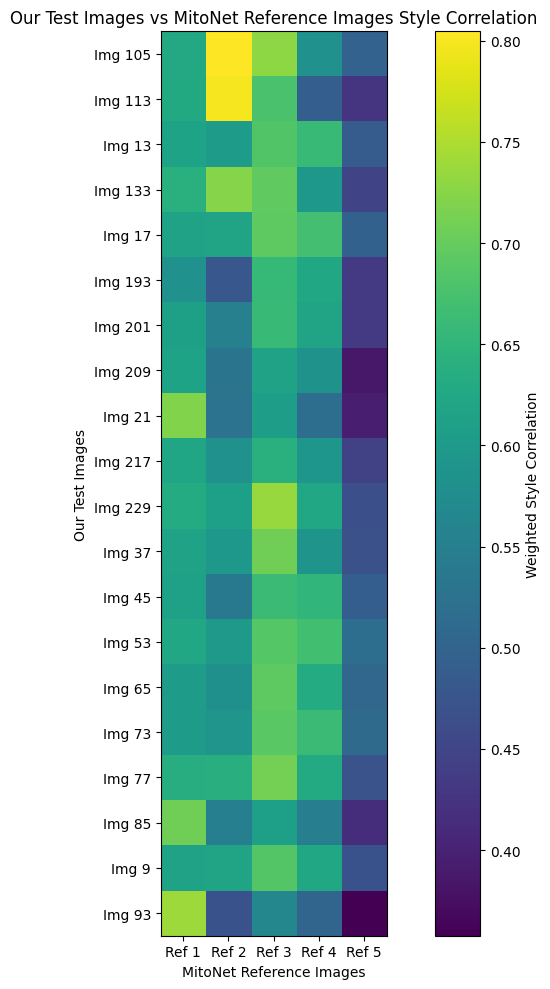

In [3]:
import matplotlib.pyplot as plt 
from PIL import Image
import numpy as np

# Constants
model_path = "/home/idies/workspace/Storage/xyu1/persistent/micro-sam/finetuning/PytorchNeuralStyleTransfer/Models/vgg_conv.pth"
style_layers = ['r11','r21','r31','r41', 'r51']
#style_weights = [1.0] * len(style_layers)
#style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
scales = [1, 1, 1, 1, 1]
style_weights = [n**2/1e4 for n, s in zip([64,128,256,512,512], scales)]

vgg = load_vgg_model(model_path)

def extract_features(image_path):
    img_name = os.path.basename(image_path)
    image_tensor = load_and_preprocess_png(os.path.dirname(image_path) + "/", [img_name])[0]
    features = [GramMatrix()(f).detach() for f in vgg(image_tensor, style_layers)]
    return features

#/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/src/examples/mitochondria1.png
prompt_sets = [
    {
        "name": "MitoNet_reference_1",
        "image": "/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/src/examples/mitochondria1.png",
        "mask":  "/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/src/examples/mitochondria1_target.png"
    },
    {
        "name": "MitoNet_reference_2",
        "image": "/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/src/examples/mitochondria2.png",
        "mask":  "/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/src/examples/mitochondria2_target.png"
    },
    {
        "name": "MitoNet_reference_3",
        "image": "/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/src/examples/mitochondria3.png",
        "mask":  "/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/src/examples/mitochondria3_target.png"
    },
    {
        "name": "MitoNet_reference_4",
        "image": "/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/src/examples/mitochondria4.png",
        "mask":  "/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/src/examples/mitochondria4_target.png"
    },
    {
        "name": "MitoNet_reference_5",
        "image": "/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/src/examples/mitochondria5.png",
        "mask":  "/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/src/examples/mitochondria5_target.png"
    }
]


image_index_list = [105,113,13,133,17,193,201,209,21,217,229,37,45,53,65,73,77,85,9,93]
base_img_path = "/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/test_images/mito/images/image_{}.png"
base_label_path = "/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/test_images/mito/labels/label_{}.png"


# Load images
val_images = [item["image"] for item in prompt_sets]
test_images = [base_img_path.format(idx) for idx in image_index_list]

# Extract features (define this function elsewhere or import it)
val_features = [extract_features(img) for img in val_images]
test_features = [extract_features(img) for img in test_images]

# Define your style_weights before this loop
# Example: style_weights = {"color": 0.3, "texture": 0.7}
# or however your weighted_style_correlation function is defined

scores = np.zeros((len(test_features), len(val_features)))  # 10x9

# Compute weighted correlation scores
for i, tf in enumerate(test_features):
    for j, vf in enumerate(val_features):
        scores[i, j] = weighted_style_correlation(vf, tf, style_weights)

# Convert to numpy array if needed
correlation_matrix = np.array(scores)

# Display matrix
plt.figure(figsize=(10, 10))
plt.imshow(correlation_matrix, cmap='viridis')
plt.colorbar(label="Weighted Style Correlation")

# X-axis: 5 reference images
plt.xlabel("MitoNet Reference Images")
plt.xticks(ticks=np.arange(len(prompt_sets)), labels=[f"Ref {i+1}" for i in range(len(prompt_sets))])

# Y-axis: 20 test images
plt.ylabel("Our Test Images")
plt.yticks(ticks=np.arange(len(image_index_list)), labels=[f"Img {idx}" for idx in image_index_list])

plt.title("Our Test Images vs MitoNet Reference Images Style Correlation")
plt.tight_layout()
plt.show()

In [ ]:
# search_query = "Viusal Characteristics of mitochondria"
# result_json = google_search_summary(search_query)
# print(result_json)
# #Save to a file
# output_filename = "mitochondria_visual_characteristics.json"
# with open(output_filename, "w", encoding="utf-8") as f:
#     json.dump(result_json, f, ensure_ascii=False, indent=2)

# print(f"Results saved to {output_filename}")

In [4]:
input_filename = "mitochondria_visual_characteristics.json"

# Read the file
with open(input_filename, "r", encoding="utf-8") as f:
    data = json.load(f)

# Now you can use `data` like a regular Python dictionary
print(data)

result_dict = json.loads(data)

# Now extract the segmentation prompt
segmentation_prompt = result_dict["summary"]["segmentation_prompt"]
visual_characteristics = result_dict["summary"]["visual_characteristics"]

{
  "top_results": [
    {
      "position": 1,
      "title": "Mitochondria - The Cell - NCBI Bookshelf",
      "link": "https://www.ncbi.nlm.nih.gov/books/NBK9896/",
      "snippet": "Mitochondria are surrounded by a double-membrane system, consisting of inner and outer mitochondrial membranes separated by an intermembrane space (Figure 10.1) ..."
    },
    {
      "position": 2,
      "title": "Mitochondria Definition",
      "link": "https://byjus.com/biology/mitochondria/",
      "snippet": "The mitochondrion is a double-membraned, rod-shaped structure found in both plant and animal cell. \u00b7 Its size ranges from 0.5 to 1.0 micrometre in diameter. \u00b7 The ..."
    },
    {
      "position": 3,
      "title": "Mitochondrion",
      "link": "https://en.wikipedia.org/wiki/Mitochondrion",
      "snippet": "Mitochondria have a double membrane structure and use aerobic respiration to generate adenosine triphosphate (ATP), which is used throughout the cell as a ..."
    },
    {
 


Processing image_105...
MitoNet completed and the segmentation results saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results.png, the corresponding mask saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results_mask.png
MitoNet IoU for image_105: 0.0000
Overlay image saved to: /home/idies/workspace/Storage/xyu1/persistent/Langchain/results_2_1_2/MitoNet_results/image_105.png


2025-09-30 11:31:49,555 [WARNING] [segmentation_eval] [/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/segmentation_eval.py]: Failed to parse evaluation JSON, using raw text fallback.


{
  "ReviewScore": {
    "Shape Conformity" (Weight: 0.3): 5,
    "Boundary Integrity" (Weight: 0.25): 5,
    "Object Distinctness" (Weight: 0.2): 0,
    "Size Plausibility" (Weight: 0.15): 5,
    "Naturalness of Form" (Weight: 0.1): 5,
    "OverallScore": 4.0
  },
  "Reasons": {
    "Shape Conformity" (Weight: 0.3): "The segmented regions are largely amorphous and expansive, particularly the solid red block at the top and the large, irregular blob covering the bottom. They do not visually resemble the typical elongated, oval, or bean-shaped mitochondria.",
    "Boundary Integrity" (Weight: 0.25): "The segment boundaries are extremely poor. They are not crisp, leak significantly into irrelevant cytoplasmic and background regions, and are not biologically plausible. The top boundary is an artificial straight line, and other boundaries are overly diffuse.",
    "Object Distinctness" (Weight: 0.2): "Individual mitochondria cannot be distinguished at all. The mask merges multiple potential

/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/oneshot_segGPT.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(chkpt_dir, m

One shot segmentation completed and saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/seggpt_results.png, the mask is saved in seggpt_mask_path:/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/seggpt_results_mask.png.
SegGPT IoU for image_105: 0.2442
→ SegGPT overlay saved to: /home/idies/workspace/Storage/xyu1/persistent/Langchain/results_2_1_2/MitoNet_results/image_105_seggpt.png


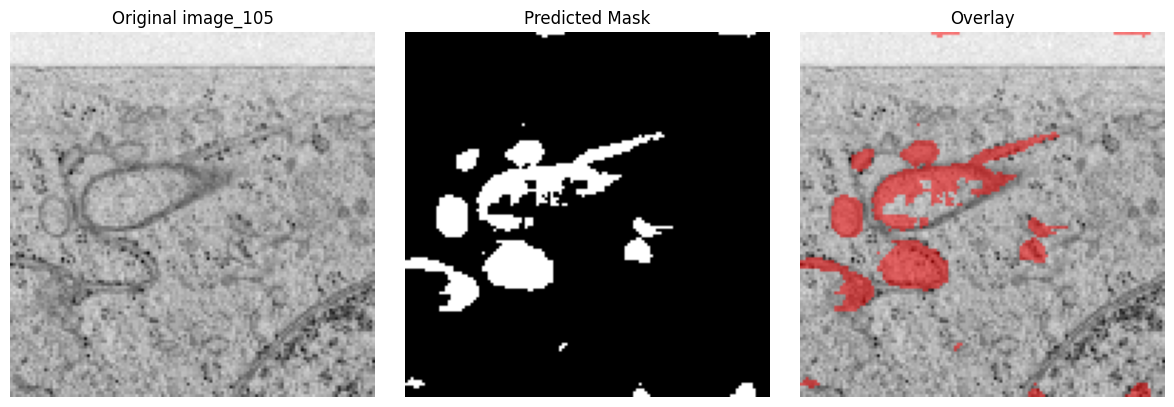


Processing image_113...
MitoNet completed and the segmentation results saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results.png, the corresponding mask saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results_mask.png
MitoNet IoU for image_113: 0.0000
Overlay image saved to: /home/idies/workspace/Storage/xyu1/persistent/Langchain/results_2_1_2/MitoNet_results/image_113.png


2025-09-30 11:32:20,690 [WARNING] [segmentation_eval] [/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/segmentation_eval.py]: Failed to parse evaluation JSON, using raw text fallback.


{
  "ReviewScore": {
    "Shape Conformity" (Weight: 0.3): 0,
    "Boundary Integrity" (Weight: 0.25): 0,
    "Object Distinctness" (Weight: 0.2): 0,
    "Size Plausibility" (Weight: 0.15): 0,
    "Naturalness of Form" (Weight: 0.1): 0,
    "OverallScore": 0
  },
  "Reasons": {
    "Shape Conformity" (Weight: 0.3): "No segmented structures are visible in the image, therefore shape conformity cannot be assessed.",
    "Boundary Integrity" (Weight: 0.25): "There are no red-highlighted areas, meaning no segment boundaries are present to evaluate for crispness or completeness.",
    "Object Distinctness" (Weight: 0.2): "No objects are identified or highlighted in red, indicating a complete failure to distinguish any structures.",
    "Size Plausibility" (Weight: 0.15): "Without any segmentation masks, there are no regions whose size can be evaluated for plausibility.",
    "Naturalness of Form" (Weight: 0.1): "As no forms are segmented, their naturalness or realism cannot be judged."
  },


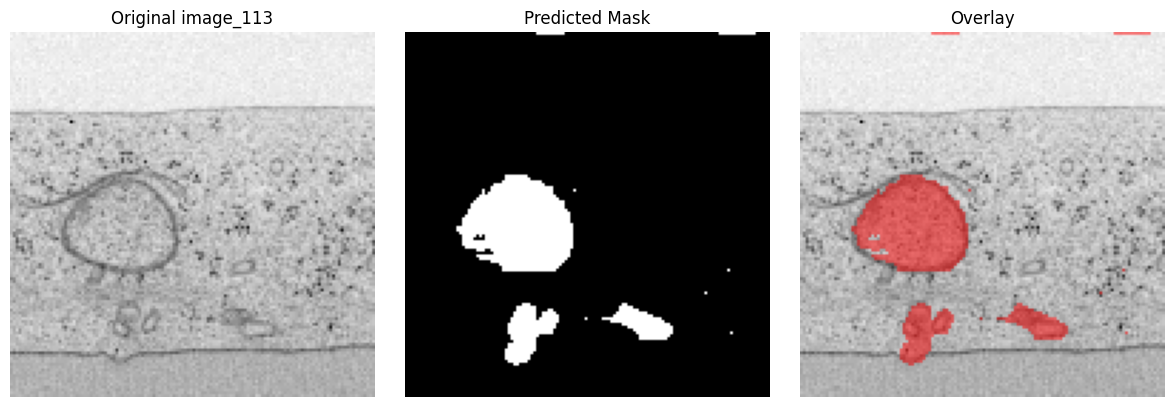


Processing image_13...
MitoNet completed and the segmentation results saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results.png, the corresponding mask saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results_mask.png
MitoNet IoU for image_13: 0.6005
Overlay image saved to: /home/idies/workspace/Storage/xyu1/persistent/Langchain/results_2_1_2/MitoNet_results/image_13.png


2025-09-30 11:32:52,339 [WARNING] [segmentation_eval] [/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/segmentation_eval.py]: Failed to parse evaluation JSON, using raw text fallback.


{
  "ReviewScore": {
    "Shape Conformity" (Weight: 0.3): 90,
    "Boundary Integrity" (Weight: 0.25): 90,
    "Object Distinctness" (Weight: 0.2): 95,
    "Size Plausibility" (Weight: 0.15): 95,
    "Naturalness of Form" (Weight: 0.1): 90,
    "OverallScore": 91.75
  },
  "Reasons": {
    "Shape Conformity" (Weight: 0.3): "The segmented regions clearly resemble mitochondria, exhibiting characteristic oval and elongated bean-like shapes. They are not blocky or unstructured, unlike the first reference image.",
    "Boundary Integrity" (Weight: 0.25): "The segment boundaries are crisp and accurately follow the outlines of the mitochondrial structures. There are no visible gaps, leaks, or bleeding into irrelevant background areas, which is a significant improvement over the first reference.",
    "Object Distinctness" (Weight: 0.2): "Individual mitochondria are very well distinguished from one another. Each red region corresponds to a separate, identifiable mitochondrion, demonstrating e

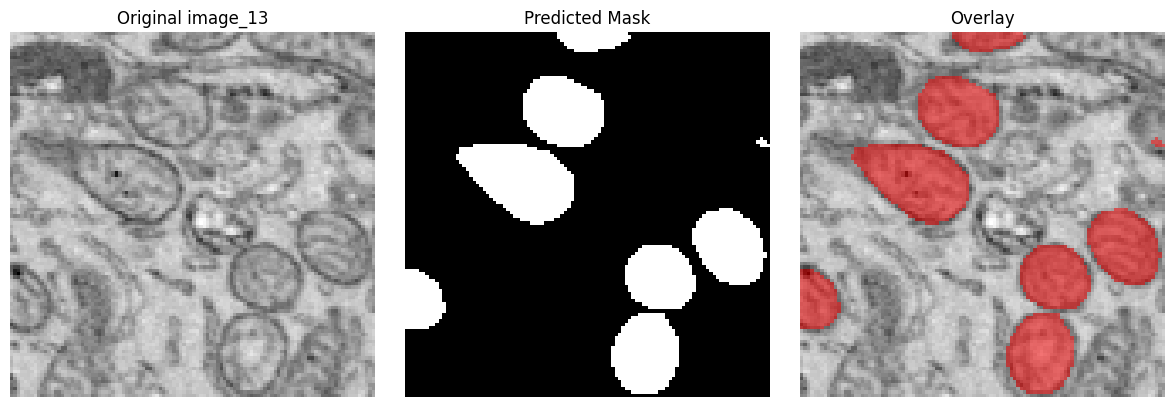


Processing image_133...
MitoNet completed and the segmentation results saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results.png, the corresponding mask saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results_mask.png
MitoNet IoU for image_133: 0.7048
Overlay image saved to: /home/idies/workspace/Storage/xyu1/persistent/Langchain/results_2_1_2/MitoNet_results/image_133.png


2025-09-30 11:33:26,911 [WARNING] [segmentation_eval] [/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/segmentation_eval.py]: Failed to parse evaluation JSON, using raw text fallback.


{
  "ReviewScore": {
    "Shape Conformity" (Weight: 0.3): 85,
    "Boundary Integrity" (Weight: 0.25): 85,
    "Object Distinctness" (Weight: 0.2): 90,
    "Size Plausibility" (Weight: 0.15): 90,
    "Naturalness of Form" (Weight: 0.1): 85,
    "OverallScore": 86.75
  },
  "Reasons": {
    "Shape Conformity" (Weight: 0.3): "The segmented regions clearly resemble elongated, oval, or bean-shaped mitochondria. They are not blocky or overly jagged, aligning well with expected mitochondrial morphology.",
    "Boundary Integrity" (Weight: 0.25): "The segment boundaries are generally crisp and follow the contours of the underlying structures well. There are no major gaps or leaks into irrelevant background regions, indicating good adherence to the object's edges.",
    "Object Distinctness" (Weight: 0.2): "Two distinct mitochondria are clearly identified and separated from each other and the surrounding cellular environment. This demonstrates excellent object distinctness for the structures 

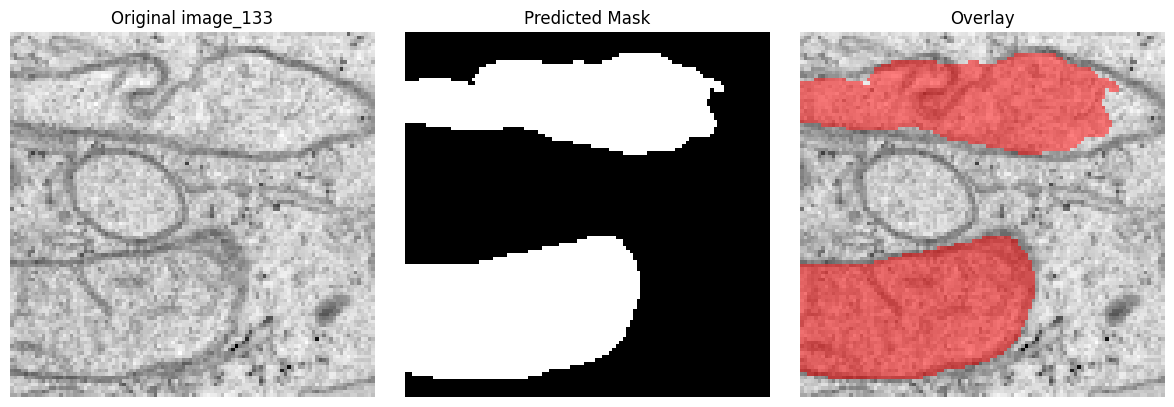


Processing image_17...
MitoNet completed and the segmentation results saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results.png, the corresponding mask saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results_mask.png
MitoNet IoU for image_17: 0.8629
Overlay image saved to: /home/idies/workspace/Storage/xyu1/persistent/Langchain/results_2_1_2/MitoNet_results/image_17.png


2025-09-30 11:33:57,356 [WARNING] [segmentation_eval] [/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/segmentation_eval.py]: Failed to parse evaluation JSON, using raw text fallback.


{
  "ReviewScore": {
    "Shape Conformity" (Weight: 0.3): 90,
    "Boundary Integrity" (Weight: 0.25): 90,
    "Object Distinctness" (Weight: 0.2): 90,
    "Size Plausibility" (Weight: 0.15): 90,
    "Naturalness of Form" (Weight: 0.1): 90,
    "OverallScore": 90
  },
  "Reasons": {
    "Shape Conformity" (Weight: 0.3): "The segmented region is a distinct oval/bean shape, which closely matches the expected morphology of a mitochondrion. It avoids blocky or jagged outlines.",
    "Boundary Integrity" (Weight: 0.25): "The red mask tightly adheres to the visible boundary of the underlying biological structure. The edges are crisp and complete, with no apparent leaks or gaps into surrounding areas.",
    "Object Distinctness" (Weight: 0.2): "The single segmented object is clearly distinct from the background and other unsegmented regions. It is well-defined as an individual entity.",
    "Size Plausibility" (Weight: 0.15): "The size of the segmented region is appropriate and visually plau

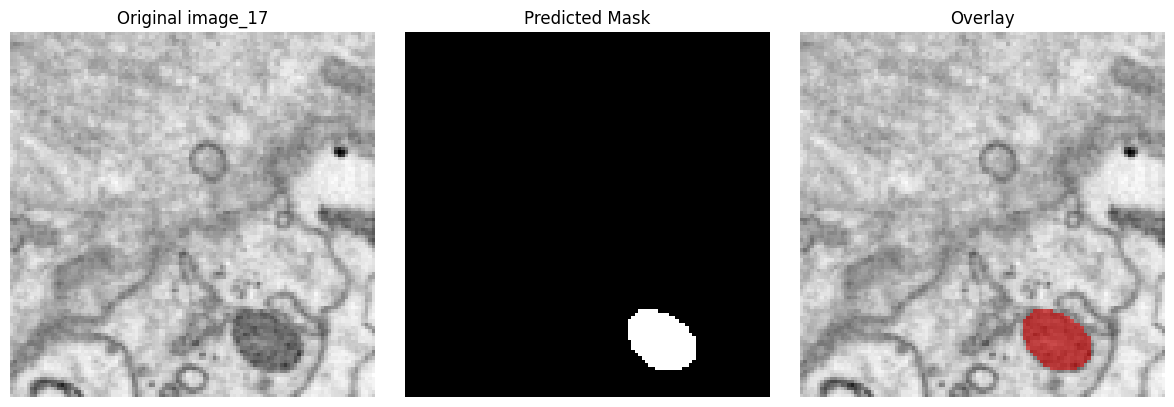


Processing image_193...
MitoNet completed and the segmentation results saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results.png, the corresponding mask saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results_mask.png
MitoNet IoU for image_193: 0.7955
Overlay image saved to: /home/idies/workspace/Storage/xyu1/persistent/Langchain/results_2_1_2/MitoNet_results/image_193.png


2025-09-30 11:34:29,164 [WARNING] [segmentation_eval] [/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/segmentation_eval.py]: Failed to parse evaluation JSON, using raw text fallback.


{
  "ReviewScore": {
    "Shape Conformity" (Weight: 0.3): 85,
    "Boundary Integrity" (Weight: 0.25): 90,
    "Object Distinctness" (Weight: 0.2): 90,
    "Size Plausibility" (Weight: 0.15): 90,
    "Naturalness of Form" (Weight: 0.1): 90,
    "OverallScore": 88.5
  },
  "Reasons": {
    "Shape Conformity" (Weight: 0.3): "The segmented region is a clear, distinct oval/circular shape that closely matches the visual appearance of the large central mitochondrion. It avoids blocky or jagged outlines, showing good conformity to expected mitochondrial morphology.",
    "Boundary Integrity" (Weight: 0.25): "The red mask's boundary is crisp, complete, and accurately follows the inner contour of the central organelle. It does not leak into surrounding irrelevant regions, demonstrating strong boundary integrity.",
    "Object Distinctness" (Weight: 0.2): "The single segmented object is clearly distinct from the background and other structures in the image. While only one object is identified, 

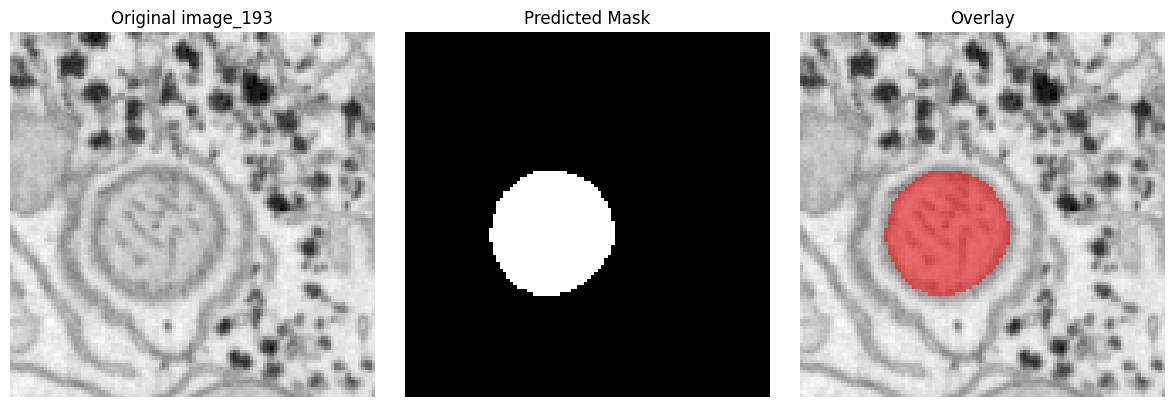


Processing image_201...
MitoNet completed and the segmentation results saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results.png, the corresponding mask saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results_mask.png
MitoNet IoU for image_201: 0.9537
Overlay image saved to: /home/idies/workspace/Storage/xyu1/persistent/Langchain/results_2_1_2/MitoNet_results/image_201.png


2025-09-30 11:35:03,540 [WARNING] [segmentation_eval] [/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/segmentation_eval.py]: Failed to parse evaluation JSON, using raw text fallback.


{
  "ReviewScore": {
    "Shape Conformity" (Weight: 0.3): 95,
    "Boundary Integrity" (Weight: 0.25): 90,
    "Object Distinctness" (Weight: 0.2): 95,
    "Size Plausibility" (Weight: 0.15): 95,
    "Naturalness of Form" (Weight: 0.1): 90,
    "OverallScore": 93.25
  },
  "Reasons": {
    "Shape Conformity" (Weight: 0.3): "The segmented regions accurately capture the characteristic elongated, oval, or bean-like shapes of mitochondria. They are well-formed and avoid the blocky, jagged, or unstructured outlines seen in poor segmentations.",
    "Boundary Integrity" (Weight: 0.25): "The segment boundaries are generally crisp and complete, closely following the outer membranes of the mitochondria. There are no major gaps or leaks into irrelevant regions, indicating good adherence to the biological structures.",
    "Object Distinctness" (Weight: 0.2): "Individual mitochondria are clearly distinguished from one another. Each red region corresponds to a single, separate mitochondrion, even

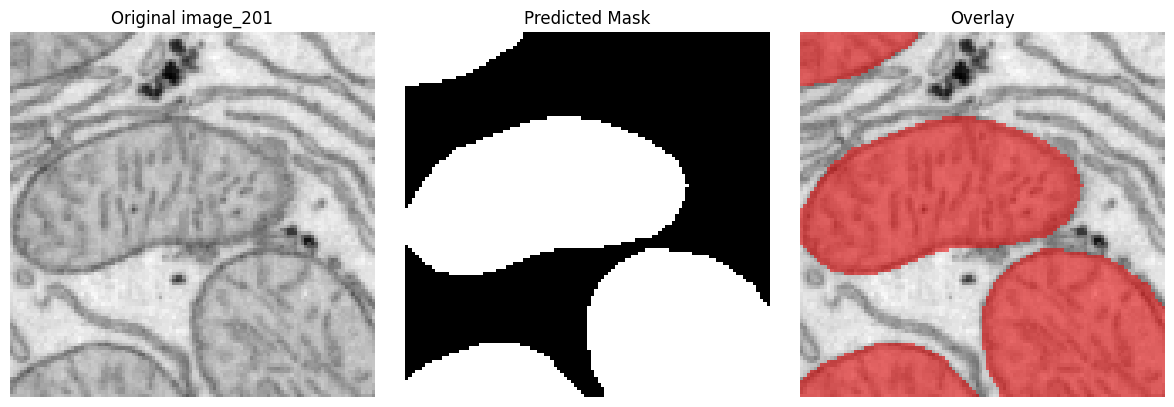


Processing image_209...
MitoNet completed and the segmentation results saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results.png, the corresponding mask saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results_mask.png
MitoNet IoU for image_209: 0.9329
Overlay image saved to: /home/idies/workspace/Storage/xyu1/persistent/Langchain/results_2_1_2/MitoNet_results/image_209.png


2025-09-30 11:35:36,030 [WARNING] [segmentation_eval] [/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/segmentation_eval.py]: Failed to parse evaluation JSON, using raw text fallback.


{
  "ReviewScore": {
    "Shape Conformity" (Weight: 0.3): 90,
    "Boundary Integrity" (Weight: 0.25): 85,
    "Object Distinctness" (Weight: 0.2): 95,
    "Size Plausibility" (Weight: 0.15): 90,
    "Naturalness of Form" (Weight: 0.1): 88,
    "OverallScore": 89.55
  },
  "Reasons": {
    "Shape Conformity" (Weight: 0.3): "The segmented regions visually resemble mitochondria, exhibiting plausible oval to circular shapes consistent with cross-sections of these organelles. The outlines are smooth and avoid blocky or jagged forms.",
    "Boundary Integrity" (Weight: 0.25): "The segment boundaries are generally crisp and follow the outer membrane of the mitochondria accurately. There are no major gaps or leaks into surrounding irrelevant regions, indicating good containment.",
    "Object Distinctness" (Weight: 0.2): "Individual mitochondria are clearly distinguished from one another. Each segmented region corresponds to a single, separate mitochondrion, without merging or fragmentation 

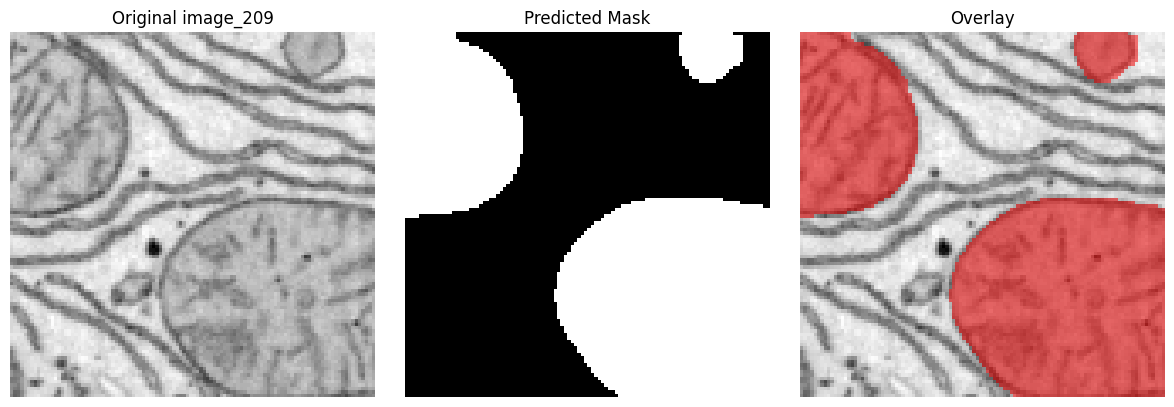


Processing image_21...
MitoNet completed and the segmentation results saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results.png, the corresponding mask saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results_mask.png
MitoNet IoU for image_21: 0.6129
Overlay image saved to: /home/idies/workspace/Storage/xyu1/persistent/Langchain/results_2_1_2/MitoNet_results/image_21.png


2025-09-30 11:36:02,762 [WARNING] [segmentation_eval] [/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/segmentation_eval.py]: Failed to parse evaluation JSON, using raw text fallback.


{
  "ReviewScore": {
    "Shape Conformity" (Weight: 0.3): 80,
    "Boundary Integrity" (Weight: 0.25): 85,
    "Object Distinctness" (Weight: 0.2): 90,
    "Size Plausibility" (Weight: 0.15): 85,
    "Naturalness of Form" (Weight: 0.1): 80,
    "OverallScore": 84
  },
  "Reasons": {
    "Shape Conformity" (Weight: 0.3): "The segmented regions generally exhibit plausible mitochondrial shapes, appearing as distinct oval or bean-like structures. They are not blocky or jagged, unlike the amorphous mass in Reference 1.",
    "Boundary Integrity" (Weight: 0.25): "The segment boundaries are relatively crisp and appear to accurately follow the contours of the underlying biological structures. There are no obvious leaks or major gaps, indicating good adherence to the object's edges.",
    "Object Distinctness" (Weight: 0.2): "Individual mitochondria are clearly distinguished from one another. Each red-highlighted area represents a separate object, which is a significant improvement over Refere

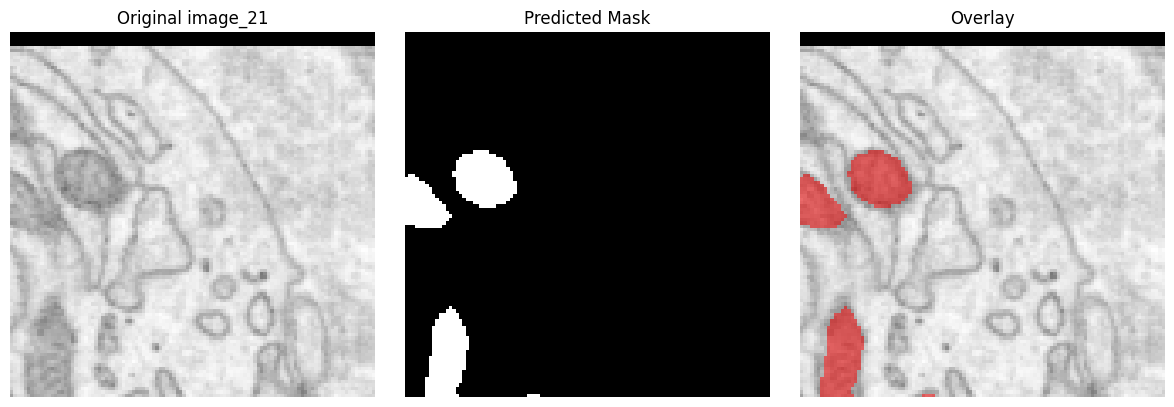


Processing image_217...
MitoNet completed and the segmentation results saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results.png, the corresponding mask saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results_mask.png
MitoNet IoU for image_217: 0.9232
Overlay image saved to: /home/idies/workspace/Storage/xyu1/persistent/Langchain/results_2_1_2/MitoNet_results/image_217.png


2025-09-30 11:36:40,607 [WARNING] [segmentation_eval] [/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/segmentation_eval.py]: Failed to parse evaluation JSON, using raw text fallback.


{
  "ReviewScore": {
    "Shape Conformity" (Weight: 0.3): 70,
    "Boundary Integrity" (Weight: 0.25): 75,
    "Object Distinctness" (Weight: 0.2): 90,
    "Size Plausibility" (Weight: 0.15): 80,
    "Naturalness of Form" (Weight: 0.1): 70,
    "OverallScore": 76.75
  },
  "Reasons": {
    "Shape Conformity" (Weight: 0.3): "The mask generally follows the elongated, somewhat bean-like shape of the mitochondrion. However, it's overly smoothed and doesn't capture the finer contours or slight irregularities of the actual organelle membrane. The thin, uniform extension to the right is also somewhat simplified.",
    "Boundary Integrity" (Weight: 0.25): "The boundaries are mostly complete and crisp, clearly delineating the segmented region from the background. There are no obvious leaks or major gaps. However, the mask's boundaries don't perfectly align with the visible outer membrane of the mitochondrion, showing some slight under-segmentation in parts and over-smoothing in others.",
    "

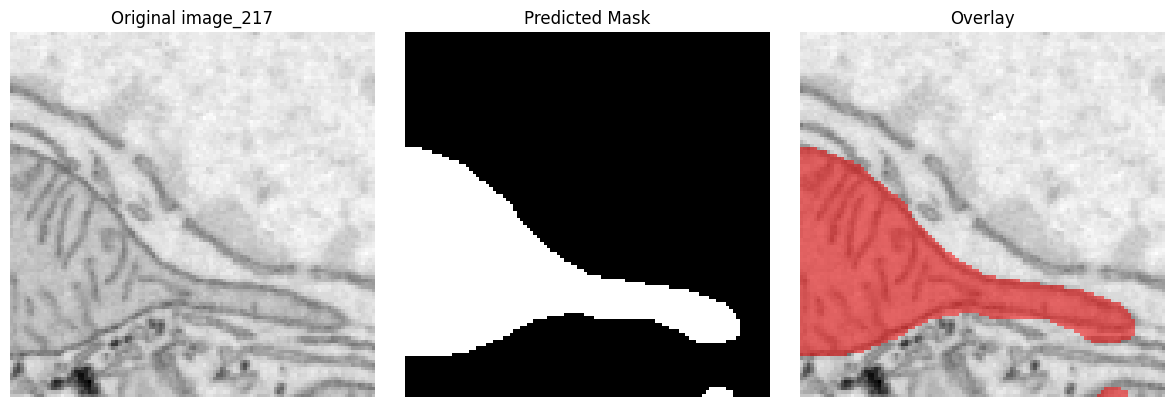


Processing image_229...
MitoNet completed and the segmentation results saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results.png, the corresponding mask saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results_mask.png
MitoNet IoU for image_229: 0.9438
Overlay image saved to: /home/idies/workspace/Storage/xyu1/persistent/Langchain/results_2_1_2/MitoNet_results/image_229.png


2025-09-30 11:37:20,608 [WARNING] [segmentation_eval] [/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/segmentation_eval.py]: Failed to parse evaluation JSON, using raw text fallback.


{
  "ReviewScore": {
    "Shape Conformity" (Weight: 0.3): 80,
    "Boundary Integrity" (Weight: 0.25): 95,
    "Object Distinctness" (Weight: 0.2): 65,
    "Size Plausibility" (Weight: 0.15): 95,
    "Naturalness of Form" (Weight: 0.1): 80,
    "OverallScore": 83.0
  },
  "Reasons": {
    "Shape Conformity" (Weight: 0.3): "The segmented regions are generally oval or circular, which are plausible shapes for mitochondria. They avoid blocky or jagged outlines. However, they appear somewhat overly smoothed and idealized, lacking some of the subtle irregularities expected in natural biological forms.",
    "Boundary Integrity" (Weight: 0.25): "The boundaries of the segmented regions are very crisp, complete, and accurately follow the outer membrane of the mitochondria. There are no visible gaps or leaks into surrounding irrelevant regions, demonstrating excellent boundary delineation.",
    "Object Distinctness" (Weight: 0.2): "The two segmented mitochondria are clearly distinct from each 

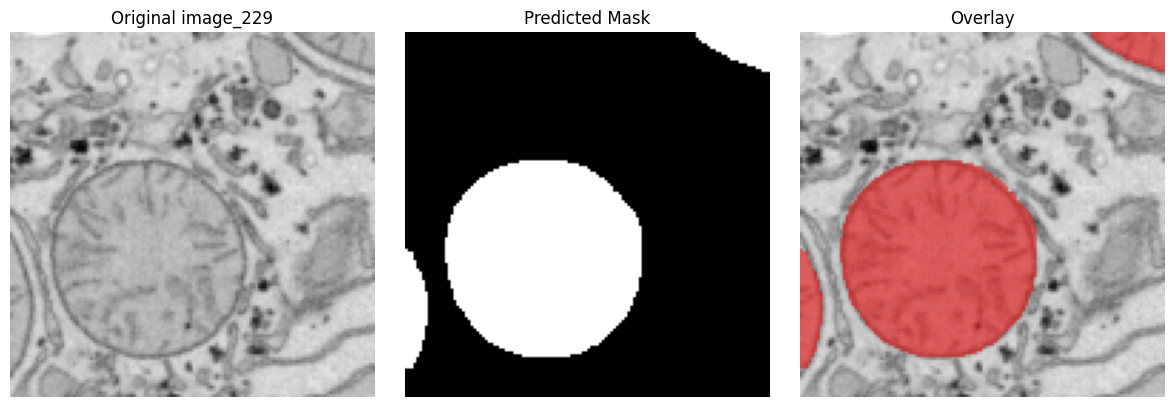


Processing image_37...
MitoNet completed and the segmentation results saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results.png, the corresponding mask saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results_mask.png
MitoNet IoU for image_37: 0.4398
Overlay image saved to: /home/idies/workspace/Storage/xyu1/persistent/Langchain/results_2_1_2/MitoNet_results/image_37.png


2025-09-30 11:37:46,604 [WARNING] [segmentation_eval] [/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/segmentation_eval.py]: Failed to parse evaluation JSON, using raw text fallback.


{
  "ReviewScore": {
    "Shape Conformity" (Weight: 0.3): 95,
    "Boundary Integrity" (Weight: 0.25): 90,
    "Object Distinctness" (Weight: 0.2): 95,
    "Size Plausibility" (Weight: 0.15): 90,
    "Naturalness of Form" (Weight: 0.1): 90,
    "OverallScore": 92.5
  },
  "Reasons": {
    "Shape Conformity" (Weight: 0.3): "The segmented regions (highlighted in red) exhibit excellent shape conformity, accurately capturing the elongated, oval, and bean-like forms characteristic of mitochondria. They are not blocky, jagged, or unstructured.",
    "Boundary Integrity" (Weight: 0.25): "The boundaries of the segmented objects are generally crisp, well-defined, and complete. There are no significant gaps or leaks into irrelevant background regions, indicating good containment of the identified structures.",
    "Object Distinctness" (Weight: 0.2): "Each segmented region clearly represents an individual mitochondrion, and there is no merging or overlap between the detected objects. They are d

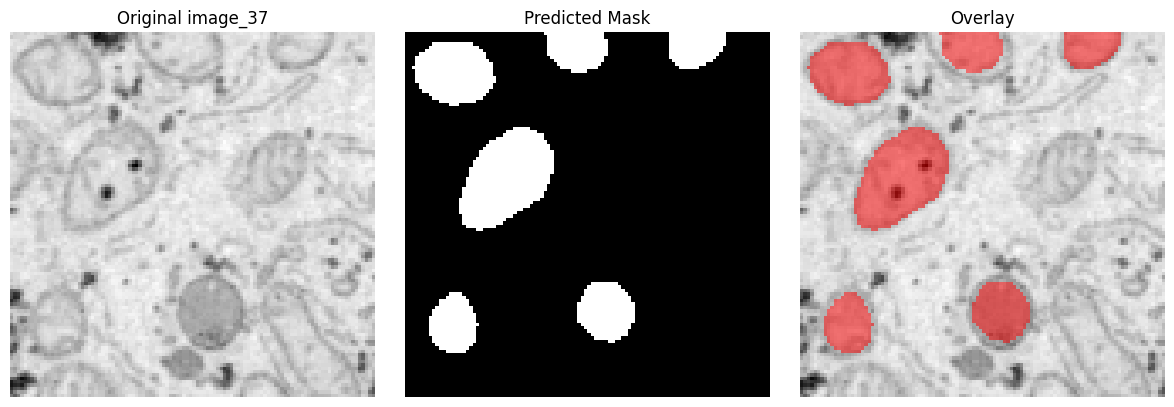


Processing image_45...
MitoNet completed and the segmentation results saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results.png, the corresponding mask saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results_mask.png
MitoNet IoU for image_45: 0.3344
Overlay image saved to: /home/idies/workspace/Storage/xyu1/persistent/Langchain/results_2_1_2/MitoNet_results/image_45.png


2025-09-30 11:38:22,304 [WARNING] [segmentation_eval] [/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/segmentation_eval.py]: Failed to parse evaluation JSON, using raw text fallback.


{
  "ReviewScore": {
    "Shape Conformity" (Weight: 0.3): 85,
    "Boundary Integrity" (Weight: 0.25): 85,
    "Object Distinctness" (Weight: 0.2): 80,
    "Size Plausibility" (Weight: 0.15): 90,
    "Naturalness of Form" (Weight: 0.1): 85,
    "OverallScore": 84.75
  },
  "Reasons": {
    "Shape Conformity" (Weight: 0.3): "The segmented regions clearly resemble the expected elongated, oval, or bean-shaped forms of mitochondria. They are not blocky, jagged, or amorphous, showing good adherence to biological shapes.",
    "Boundary Integrity" (Weight: 0.25): "The segment boundaries are generally crisp and follow the contours of the underlying structures well. There are no major gaps or leaks into irrelevant background regions, indicating good delineation.",
    "Object Distinctness" (Weight: 0.2): "Individual mitochondria are largely distinguishable from one another. Even in denser areas, such as the cluster on the left, several distinct elongated structures are identified, avoiding th

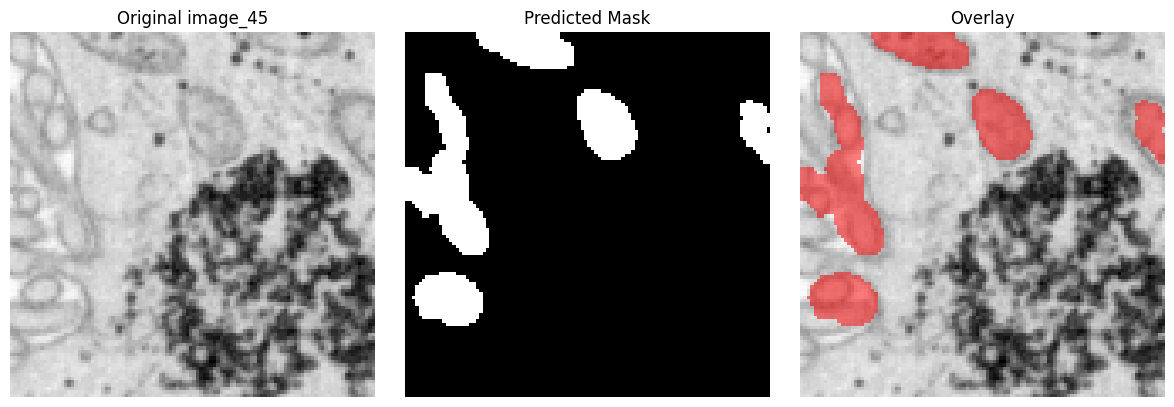


Processing image_53...
MitoNet completed and the segmentation results saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results.png, the corresponding mask saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results_mask.png
MitoNet IoU for image_53: 0.6775
Overlay image saved to: /home/idies/workspace/Storage/xyu1/persistent/Langchain/results_2_1_2/MitoNet_results/image_53.png


2025-09-30 11:38:50,596 [WARNING] [segmentation_eval] [/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/segmentation_eval.py]: Failed to parse evaluation JSON, using raw text fallback.


{
  "ReviewScore": {
    "Shape Conformity" (Weight: 0.3): 85,
    "Boundary Integrity" (Weight: 0.25): 80,
    "Object Distinctness" (Weight: 0.2): 90,
    "Size Plausibility" (Weight: 0.15): 90,
    "Naturalness of Form" (Weight: 0.1): 85,
    "OverallScore": 85.25
  },
  "Reasons": {
    "Shape Conformity" (Weight: 0.3): "The segmented regions generally exhibit the expected oval or bean-like shapes of mitochondria. They are not blocky or overly jagged, showing good adherence to typical mitochondrial morphology, a significant improvement over the reference images.",
    "Boundary Integrity" (Weight: 0.25): "The segment boundaries are mostly crisp and well-defined, effectively containing the mitochondrial structures without significant leakage into the surrounding cytoplasm. While some minor irregularities might exist, they are largely complete and biologically plausible.",
    "Object Distinctness" (Weight: 0.2): "Individual mitochondria are clearly distinguished from one another. Ea

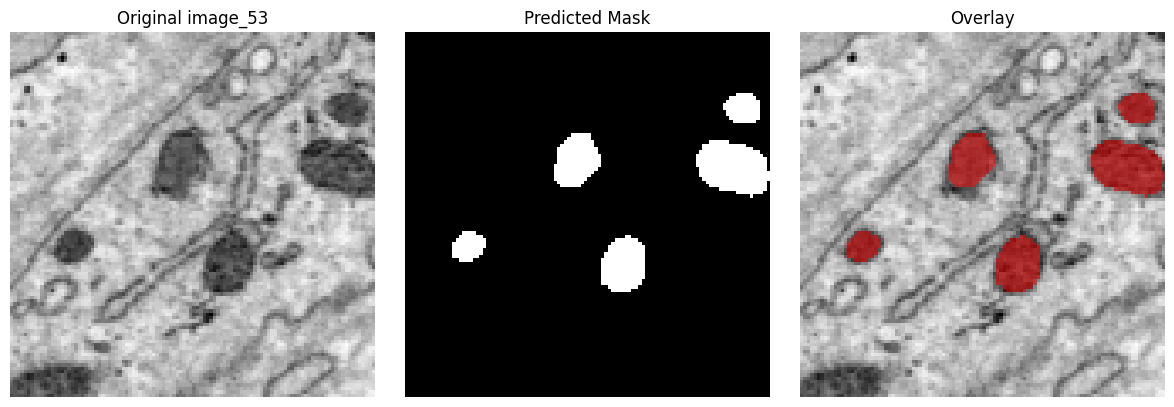


Processing image_65...
MitoNet completed and the segmentation results saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results.png, the corresponding mask saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results_mask.png
MitoNet IoU for image_65: 0.5621
Overlay image saved to: /home/idies/workspace/Storage/xyu1/persistent/Langchain/results_2_1_2/MitoNet_results/image_65.png


2025-09-30 11:39:26,847 [WARNING] [segmentation_eval] [/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/segmentation_eval.py]: Failed to parse evaluation JSON, using raw text fallback.


{
  "ReviewScore": {
    "Shape Conformity" (Weight: 0.3): 95,
    "Boundary Integrity" (Weight: 0.25): 90,
    "Object Distinctness" (Weight: 0.2): 95,
    "Size Plausibility" (Weight: 0.15): 95,
    "Naturalness of Form" (Weight: 0.1): 95,
    "OverallScore": 93.75
  },
  "Reasons": {
    "Shape Conformity" (Weight: 0.3): "The segmented regions accurately capture the elongated, oval, and bean-like shapes characteristic of mitochondria. They are not blocky, jagged, or amorphous, showing excellent conformity to expected biological forms.",
    "Boundary Integrity" (Weight: 0.25): "The boundaries of the segmented regions are crisp, well-defined, and closely adhere to the visible outlines of the mitochondria. There are no noticeable leaks into the background or significant gaps within the structures.",
    "Object Distinctness" (Weight: 0.2): "The two highlighted mitochondria are clearly distinct from each other and from the surrounding cellular environment. There is no merging or confus

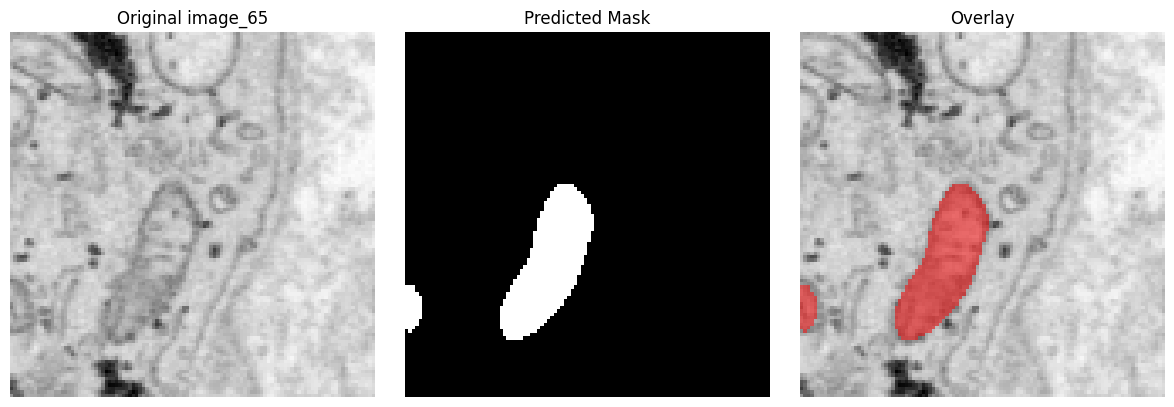


Processing image_73...
MitoNet completed and the segmentation results saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results.png, the corresponding mask saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results_mask.png
MitoNet IoU for image_73: 0.5091
Overlay image saved to: /home/idies/workspace/Storage/xyu1/persistent/Langchain/results_2_1_2/MitoNet_results/image_73.png


2025-09-30 11:40:08,446 [WARNING] [segmentation_eval] [/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/segmentation_eval.py]: Failed to parse evaluation JSON, using raw text fallback.


{
  "ReviewScore": {
    "Shape Conformity" (Weight: 0.3): 80,
    "Boundary Integrity" (Weight: 0.25): 85,
    "Object Distinctness" (Weight: 0.2): 75,
    "Size Plausibility" (Weight: 0.15): 90,
    "Naturalness of Form" (Weight: 0.1): 85,
    "OverallScore": 82.25
  },
  "Reasons": {
    "Shape Conformity" (Weight: 0.3): "The segmented regions generally exhibit elongated, oval, or bean-like shapes consistent with mitochondria. They are not overly blocky or jagged, showing good adherence to typical mitochondrial morphology.",
    "Boundary Integrity" (Weight: 0.25): "The boundaries of the segmented regions are relatively crisp and appear to follow the contours of the underlying structures well. There are no significant gaps or obvious leaks into non-mitochondrial areas.",
    "Object Distinctness" (Weight: 0.2): "The few segmented regions are clearly distinct from one another, showing no merging. While the segmentation is sparse and misses many potential mitochondria, the objects it 

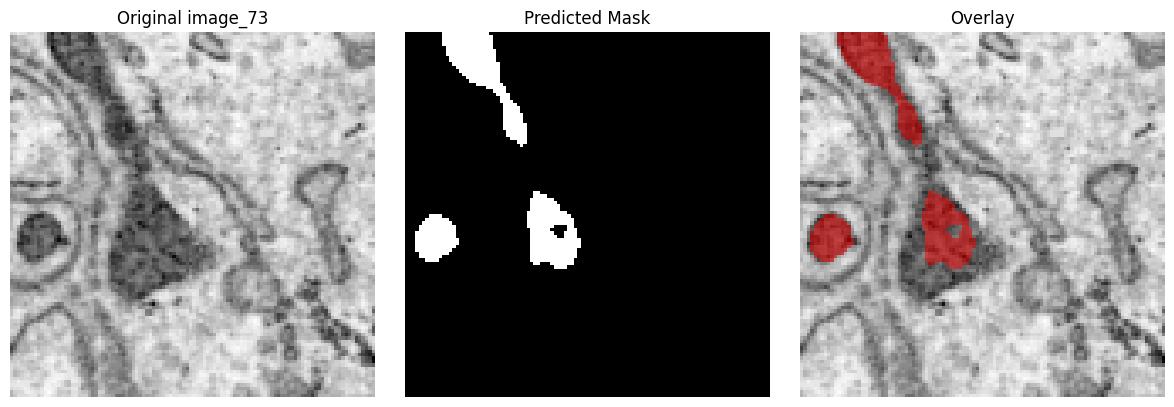


Processing image_77...
MitoNet completed and the segmentation results saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results.png, the corresponding mask saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results_mask.png
MitoNet IoU for image_77: 0.7658
Overlay image saved to: /home/idies/workspace/Storage/xyu1/persistent/Langchain/results_2_1_2/MitoNet_results/image_77.png


2025-09-30 11:40:39,399 [WARNING] [segmentation_eval] [/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/segmentation_eval.py]: Failed to parse evaluation JSON, using raw text fallback.


{
  "ReviewScore": {
    "Shape Conformity" (Weight: 0.3): 85,
    "Boundary Integrity" (Weight: 0.25): 80,
    "Object Distinctness" (Weight: 0.2): 90,
    "Size Plausibility" (Weight: 0.15): 85,
    "Naturalness of Form" (Weight: 0.1): 80,
    "OverallScore": 84.25
  },
  "Reasons": {
    "Shape Conformity" (Weight: 0.3): "The segmented regions are elongated and somewhat oval/bean-shaped, which aligns well with the typical morphology of mitochondria. They are not blocky or amorphous like the first reference image.",
    "Boundary Integrity" (Weight: 0.25): "The segment boundaries are generally crisp and complete, closely following the contours of the underlying structures. There are no major gaps or leaks into irrelevant background regions.",
    "Object Distinctness" (Weight: 0.2): "Individual mitochondria are clearly distinguished from one another, with distinct separation between the three identified structures. This is a significant improvement over the merged mass in Reference I

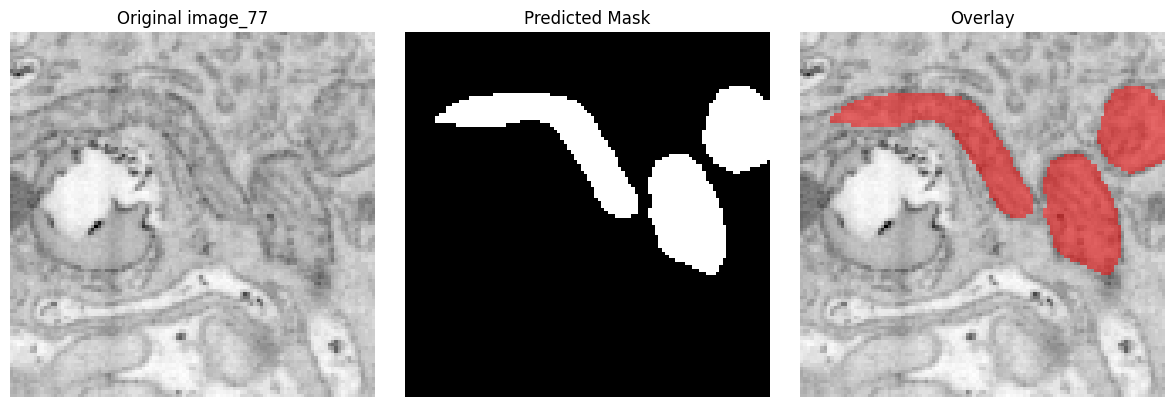


Processing image_85...
MitoNet completed and the segmentation results saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results.png, the corresponding mask saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results_mask.png
MitoNet IoU for image_85: 0.1227
Overlay image saved to: /home/idies/workspace/Storage/xyu1/persistent/Langchain/results_2_1_2/MitoNet_results/image_85.png


2025-09-30 11:41:08,525 [WARNING] [segmentation_eval] [/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/segmentation_eval.py]: Failed to parse evaluation JSON, using raw text fallback.


{
  "ReviewScore": {
    "Shape Conformity" (Weight: 0.3): 90,
    "Boundary Integrity" (Weight: 0.25): 95,
    "Object Distinctness" (Weight: 0.2): 90,
    "Size Plausibility" (Weight: 0.15): 90,
    "Naturalness of Form" (Weight: 0.1): 90,
    "OverallScore": 91.25
  },
  "Reasons": {
    "Shape Conformity" (Weight: 0.3): "The segmented region is a clear, smooth oval shape, which is highly consistent with the typical appearance of a mitochondrion in cross-section. It avoids blocky or jagged outlines.",
    "Boundary Integrity" (Weight: 0.25): "The boundaries of the segmented region are exceptionally crisp, complete, and tightly conform to the underlying biological structure without any visible leaks or gaps into irrelevant areas.",
    "Object Distinctness" (Weight: 0.2): "The single segmented object is perfectly distinct from its surroundings. There is no ambiguity or merging with other structures, demonstrating excellent distinctness for the identified region.",
    "Size Plausibil

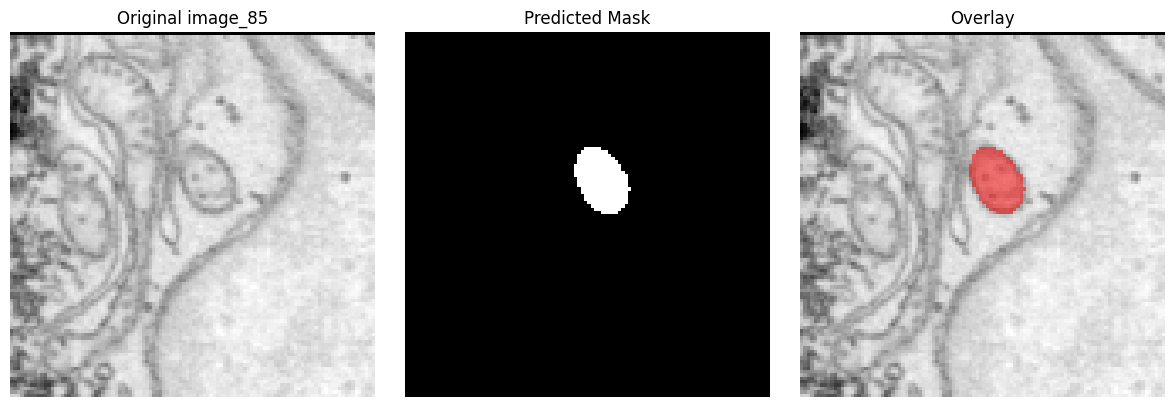


Processing image_9...
MitoNet completed and the segmentation results saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results.png, the corresponding mask saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results_mask.png
MitoNet IoU for image_9: 0.6196
Overlay image saved to: /home/idies/workspace/Storage/xyu1/persistent/Langchain/results_2_1_2/MitoNet_results/image_9.png


2025-09-30 11:41:33,720 [WARNING] [segmentation_eval] [/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/segmentation_eval.py]: Failed to parse evaluation JSON, using raw text fallback.


{
  "ReviewScore": {
    "Shape Conformity" (Weight: 0.3): 85,
    "Boundary Integrity" (Weight: 0.25): 80,
    "Object Distinctness" (Weight: 0.2): 90,
    "Size Plausibility" (Weight: 0.15): 90,
    "Naturalness of Form" (Weight: 0.1): 85,
    "OverallScore": 85.5
  },
  "Reasons": {
    "Shape Conformity" (Weight: 0.3): "The segmented regions largely conform to the expected elongated, oval, or bean-like shapes of mitochondria. They are not blocky or jagged, showing good adherence to biological form.",
    "Boundary Integrity" (Weight: 0.25): "The segment boundaries are generally crisp and follow the contours of the mitochondria well. There are no significant leaks into the background or irrelevant regions, indicating good containment.",
    "Object Distinctness" (Weight: 0.2): "Individual mitochondria are clearly distinguished from one another. There is no merging of adjacent structures, allowing for easy identification of separate objects, unlike the first reference image.",
    "S

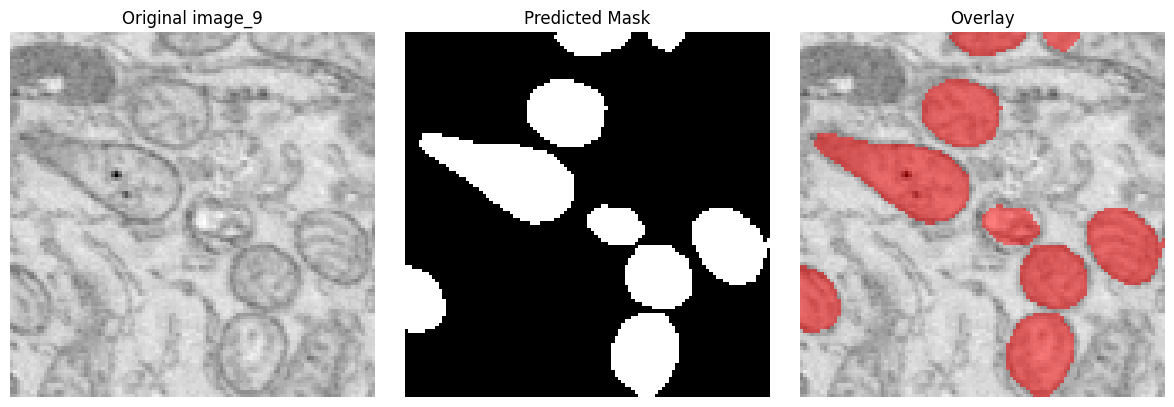


Processing image_93...
MitoNet completed and the segmentation results saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results.png, the corresponding mask saved at /home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results_mask.png
MitoNet IoU for image_93: 0.6130
Overlay image saved to: /home/idies/workspace/Storage/xyu1/persistent/Langchain/results_2_1_2/MitoNet_results/image_93.png


2025-09-30 11:41:59,319 [WARNING] [segmentation_eval] [/home/idies/workspace/Storage/xyu1/persistent/GenCELLAgent/src/tools/segmentation_eval.py]: Failed to parse evaluation JSON, using raw text fallback.


{
  "ReviewScore": {
    "Shape Conformity" (Weight: 0.3): 90,
    "Boundary Integrity" (Weight: 0.25): 90,
    "Object Distinctness" (Weight: 0.2): 100,
    "Size Plausibility" (Weight: 0.15): 90,
    "Naturalness of Form" (Weight: 0.1): 90,
    "OverallScore": 92
  },
  "Reasons": {
    "Shape Conformity" (Weight: 0.3): "The segmented regions accurately capture the elongated, oval, and bean-like shapes characteristic of mitochondria, avoiding blocky or irregular forms. They closely match the visible structures.",
    "Boundary Integrity" (Weight: 0.25): "The red masks exhibit crisp and well-defined boundaries that closely adhere to the visible outlines of the mitochondria, with no apparent leaks or significant gaps into irrelevant regions.",
    "Object Distinctness" (Weight: 0.2): "Each mitochondrion is clearly segmented as a separate entity, demonstrating excellent distinction between individual objects. There is no merging, which is a significant improvement over merged segmentati

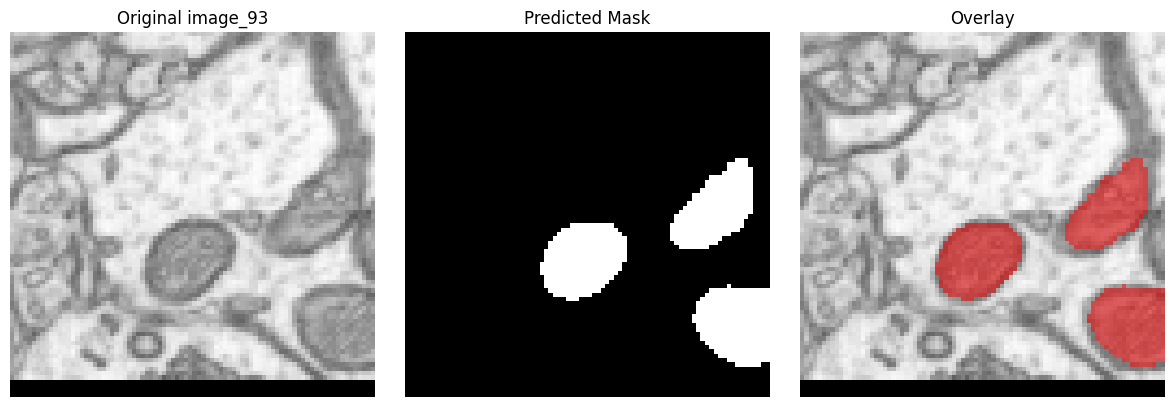


=== IoU Summary ===
Image 105: IoU = 0.2442 (Model: SegGPT)
Image 113: IoU = 0.6452 (Model: SegGPT)
Image 13: IoU = 0.6005 (Model: MitoNet)
Image 133: IoU = 0.7048 (Model: MitoNet)
Image 17: IoU = 0.8629 (Model: MitoNet)
Image 193: IoU = 0.7955 (Model: MitoNet)
Image 201: IoU = 0.9537 (Model: MitoNet)
Image 209: IoU = 0.9329 (Model: MitoNet)
Image 21: IoU = 0.6129 (Model: MitoNet)
Image 217: IoU = 0.9232 (Model: MitoNet)
Image 229: IoU = 0.9438 (Model: MitoNet)
Image 37: IoU = 0.4398 (Model: MitoNet)
Image 45: IoU = 0.3344 (Model: MitoNet)
Image 53: IoU = 0.6775 (Model: MitoNet)
Image 65: IoU = 0.5621 (Model: MitoNet)
Image 73: IoU = 0.5091 (Model: MitoNet)
Image 77: IoU = 0.7658 (Model: MitoNet)
Image 85: IoU = 0.1227 (Model: MitoNet)
Image 9: IoU = 0.6196 (Model: MitoNet)
Image 93: IoU = 0.6130 (Model: MitoNet)

Average IoU over 20 images: 0.6432


In [6]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import re
threshold = 40.00 #thesold for using in-context learning

# Function to calculate IoU
def calculate_iou(pred_mask, gt_mask):
    pred_binary = np.array(pred_mask) > 0
    gt_binary = np.array(gt_mask) > 0
    intersection = np.logical_and(pred_binary, gt_binary).sum()
    union = np.logical_or(pred_binary, gt_binary).sum()
    if union == 0:
        return float('nan')
    return intersection / union

# Paths and setup
image_index_list = [105, 113, 13, 133, 17, 193, 201, 209, 21, 217, 229, 37, 45, 53, 65, 73, 77, 85, 9, 93]
#image_index_list = [105, 113, 13]
base_img_path = "/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/test_images/mito/images/image_{}.png"
base_label_path = "/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/test_images/mito/labels/label_{}.png"
segment_mito_mask_path = "/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/MitoNet_results_mask.png"
output_dir = "/home/idies/workspace/Storage/xyu1/persistent/Langchain/results_2_1_2/MitoNet_results"
evaluation_prompt_path = "/home/idies/workspace/Storage/xyu1/persistent/Langchain/results_improve_exist/in_context_prompt_mito.json"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Store IoUs
ious = []

# Loop through images
for i, index in enumerate(image_index_list):
    print(f"\nProcessing image_{index}...")
    
    image_example_2_path = f"/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/test_images/mito/images/image_{index}.png"
    image_example_1_path = f"/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/test_images/mito/overlay_all/overlay_image_{index}.png"

    image_path = base_img_path.format(index)
    ground_truth_path = base_label_path.format(index)
    output_path = os.path.join(output_dir, f"image_{index}.png")

    # Run inference
    mitonet_inference(image_path)  ###MitoNet resutls

    # Load prediction mask
    pred_mask = Image.open(segment_mito_mask_path).convert('L')
    pred_mask_np = np.array(pred_mask)

    # Load original image
    original_img = Image.open(image_path).convert('RGB')
    original_np = np.array(original_img)

    # Load ground truth
    ground_truth = np.array(Image.open(ground_truth_path).convert('L'))

    # Compute IoU
    iou = calculate_iou(pred_mask_np, ground_truth)
    print(f"MitoNet IoU for image_{index}: {iou:.4f}")

    # Create red overlay where predicted mask is > 0
    mask = pred_mask_np > 0
    red_overlay = np.zeros_like(original_np)
    red_overlay[..., 0] = 255  # Red channel

    alpha = 0.5
    overlay_np = np.where(mask[..., None],
                          (alpha * red_overlay + (1 - alpha) * original_np).astype(np.uint8),
                          original_np)

    # Save the overlay image
    Image.fromarray(overlay_np).save(output_path)
    print(f"Overlay image saved to: {output_path}")
    
    # evualte the results
    
    outputs = segmentation_evaluator(output_path, 
                                     segmentation_prompt,
                                     evaluation_prompt_path,
                                     image_example_1_path,
                                     image_example_2_path)
    print(outputs)
    
    # Parse the JSON string first to get a dictionary
    outputs_dict = json.loads(outputs)

    # Get the evaluation text (this is the "raw_text" equivalent)
    raw_text = outputs_dict["evaluation"]

    # Clean the text (remove backticks and extra whitespace)
    cleaned_json = raw_text.strip('`').strip()

    # Remove optional "json" prefix if present
    if cleaned_json.startswith("json"):
        cleaned_json = cleaned_json[len("json"):].strip()

    # Extract the OverallScore using regex
    match = re.search(r'"OverallScore"\s*:\s*(\d+\.?\d*)', cleaned_json)
    if match:
        overall_score = float(match.group(1))
        print(f"OverallScore: {overall_score}")
    else:
        print("OverallScore not found")
        
    if overall_score >= threshold:
        print(f"→ Keeping MitoNet result for image_{index} (score = {overall_score:.4f})")
        ious.append((index, iou, "MitoNet"))
    else:
        print(f"→ MitoNet score too low ({overall_score:.4f}). Switching to SegGPT...")

        # Style correlation selection
        best_prompt_idx = np.argmax(correlation_matrix[i])  # Use current index from outer loop
        prompt_image_path = prompt_sets[best_prompt_idx]["image"]
        prompt_mask_path = prompt_sets[best_prompt_idx]["mask"]
        
        print(prompt_image_path)
        print(prompt_mask_path)

        # Run SegGPT inference
        seggpt_inference_img(image_path, prompt_image_path, prompt_mask_path)

        # Reload new mask
        # Load output
        segment_save_path = "/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/seggpt_results.png"
        segment_mask_path = "/home/idies/workspace/Storage/xyu1/persistent/Langchain/ours_test/segment_resutls/seggpt_results_mask.png"

        seg_image = Image.open(segment_save_path)
        pred_mask = Image.open(segment_mask_path).convert('L')
        pred_mask_np = np.array(pred_mask)

        # Compute IoU with ground truth
        iou_seggpt = calculate_iou(pred_mask_np, ground_truth)
        print(f"SegGPT IoU for image_{index}: {iou_seggpt:.4f}")
        ious.append((index, iou_seggpt, "SegGPT"))

        # Generate and save overlay
        mask = pred_mask_np > 0
        red_overlay = np.zeros_like(original_np)
        red_overlay[..., 0] = 255
        overlay_np = np.where(mask[..., None],
                              (alpha * red_overlay + (1 - alpha) * original_np).astype(np.uint8),
                              original_np)
        seggpt_overlay_path = os.path.join(output_dir, f"image_{index}_seggpt.png")
        Image.fromarray(overlay_np).save(seggpt_overlay_path)
        print(f"→ SegGPT overlay saved to: {seggpt_overlay_path}")
        
        
    
    # Optional: Visualize
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(original_np)
    plt.title(f"Original image_{index}")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask_np, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay_np)
    plt.title("Overlay")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Summary
print("\n=== IoU Summary ===")
for idx, iou_val, model in ious:
    print(f"Image {idx}: IoU = {iou_val:.4f} (Model: {model})")

mean_iou = np.nanmean([val for _, val, _ in ious])
print(f"\nAverage IoU over {len(ious)} images: {mean_iou:.4f}")